In [2]:
#%%
# path to working directory
path = '/Users/davidnordfors/galvanize/galvanize-capstone/final'

# IMPORT LIBRARIES
## OS
import os
os.chdir(path)

# MANAGE
import pandas as pd
import numpy as np
#from collections import Counter
from boolma import BM

## FIT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd

## GRAPHICS
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

def dist_boxplot(x, **kwargs):
    ax = sns.distplot(x, hist_kws=dict(alpha=0.2))
    ax2 = ax.twinx()
    sns.boxplot(x=x, ax=ax2)
    ax2.set(ylim=(-5, 5))


#%% DATA
## I/O
import zipfile
import requests
import pickle

# Normalization function
def norm(vec):
    return (vec-vec.mean())/vec.std()

# READ O*NET DATABASE. Search order: Dictionary, Pickle, Excel; Create dictionary/pickle if non-existent.
onet = {}
def from_onet(qualities):
        if qualities in onet:
                return onet[qualities]
        pickle_exists = os.path.isfile('./data/pickle/'+qualities+'.pkl')
        if pickle_exists:
                onet[qualities] = pd.read_pickle('./data/pickle/'+qualities+'.pkl')
                return onet[qualities]
        else: 
                onet[qualities]= pd.read_excel(
                        zipfile.ZipFile('./data/db_23_2_excel.zip').extract(
                        'db_23_2_excel/'+qualities+'.xlsx'))
                onet[qualities].to_pickle('./data/pickle/'+qualities+'.pkl')
                return onet[qualities]


# format and Strip O*NET SOC occupation codes to match the ones used by Census PUMS
def soc(socc):
    code = str(socc).replace('-','')
    return code[:5]

# CENSUS DATA: 
#%% PUMS Data dictionary
#Source: https://www.census.gov/programs-surveys/acs/data/pums.html )
datadic = pd.read_csv("./data/PUMS_Data_Dictionary_2017.csv").drop_duplicates()

# rows including the string 'word'
def var_about(word):
    return pd.concat((BM(datadic).select('Record Type', 'contains',word).df,
                      BM(datadic).select('Unnamed: 6', 'contains',word).df))

# Name of occupation for SOCP number
def socp_name(socc):
    return datadic[datadic['Record Type']== str(socc)]['Unnamed: 6'].values[0]

tits = from_onet('Alternate Titles')
all_SOCP = set(tits['O*NET-SOC Code'])


def lookup_title(socc):
    soccn = socc[:2]+'-'+socc[2:]+'.00'
    if soccn in all_SOCP:
        return tits[tits['O*NET-SOC Code']== soccn].iloc[0].get('Title')
    else:
        return 'NaN'
        
#%% select workers in ages 40 - 65 and discard the occupations with large standard deviations.
all_workers = pd.read_pickle('data/pickle/pums_California.pkl')
workers = BM(all_workers).select(
            'AGEP','gt',40).select(
            'AGEP','lt',65).df
workers['log FTE'] = workers['FTE wage'].apply(np.log)
foo = workers.groupby('SOCP') 
all_occupations = foo.mean()[['AGEP', 'FTE wage','log FTE']]
all_occupations['count'] = foo.count()['AGEP']
all_occupations['std log FTE'] = foo.std()['log FTE']
all_occupations['SOCP'] = all_occupations.index
all_occupations['SOCP_shave'] = all_occupations['SOCP'].apply(soc)
all_occupations['Occupation'] = all_occupations['SOCP']
occupations = all_occupations[all_occupations['std log FTE']<0.50]

#%%  CREATE X:features from O*NET; and y: mean wages from census/pums

def matrix(features):
    # Build X: occupation/feature matrix from O*NET
    foo = pd.get_dummies(features['Element Name']) 
    occ_features = features[['O*NET-SOC Code']].join(foo.multiply(features['Data Value'],axis = "index")).groupby('O*NET-SOC Code').sum()
    occ_features['SOCP'] = occ_features.index
    occ_features['SOCP_shave']=occ_features['SOCP'].apply(soc)
    # Group by census/PUMS SOC codes (SOCP_shave)
    occ_features_compounded= occ_features.groupby('SOCP_shave').mean()
    occ_features_compounded['SOCP_shave'] = occ_features_compounded.index   
    foo = occ_features_compounded.drop(columns='SOCP_shave')
    return foo

def xy(features,occupations):
    #Normalizes occupation matrix
    #foo = matrix(features)
    foo = features
    occ_features_norm = (foo - foo.mean())/foo.std()
    

    # Normalize y:  Census/PUMS log FTE wages   
    foo = occupations[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
    foo['log FTE'] =norm(occupations['log FTE'])

    # Merge and align X & y for occupations
    fit_data = foo.merge(occ_features_norm,left_on='SOCP_shave',right_index=True)
    
    # Return X & y
    y = fit_data['log FTE']
    X = fit_data.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
    return (X,y)


    # Normalize y:  Census/PUMS log FTE wages   
    foo = occupations[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
    foo['log FTE'] =norm(occupations['log FTE'])

    # Merge and align X & y for occupations
    fit_data = foo.merge(occ_features_norm,left_on='SOCP_shave',right_index=True)
    
    # Return X & y
    y = fit_data['log FTE']
    X = fit_data.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
    return (X,y)


# SELECT FEATURE SETS FROM O*NET, FIT FOR O*NET FTE WAGES 

# Prepare feature sets.
def prepare(df):
    # For Abilities, Knowledge, Skills
    if 'LV' in set(df['Scale ID']):
        sid = 'LV'
    # For Interests
    elif 'OI' in set(df['Scale ID']):
        sid = 'OI'
    df = df[df['Scale ID'] == sid]

    return df[['O*NET-SOC Code','Element Name','Data Value']]
    

dab = prepare(from_onet('Abilities'))
dkn = prepare(from_onet('Knowledge'))
dsk = prepare(from_onet('Skills'))
din = prepare(from_onet('Interests'))

featurenames = ['Abilities','Knowledge','Skills','Interests']

# Put them all together in one big feature matrix
dall = pd.concat([matrix(dab),matrix(dsk),matrix(dkn)],axis = 1)

#%% MODEL & FIT


# CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# Use non-zero matrix factorization for clustering
# Use singular value decomposition first state for determining overall similarity

In [3]:
class OnetCluster:
    def __init__(self,X,n):
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(X)
        self.o = pd.DataFrame(self.w,index=X.index)
        self.on = nrmcol(self.o.T).T
        self.ont = self.on.reset_index()['SOCP_shave'].apply(lookup_title)
        self.h = self.model.components_
        self.f = pd.DataFrame(self.h,columns=X.columns)
        self.fn = nrmcol(self.f.T).T
        
    


class Svd:
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)
        
def nrmcol(df):
    return df / np.sqrt(np.diagonal(df.T @ df))

In [2]:
#Select PUMS data for occupations in an OnetCluster. 
#Default threshold set to 0.7: only occupations with at least 0.49 of their weight in the cluster are included. 

def clocc(n_order,m_cluster,thresh = 0.7):
    soccs = clcat[n_order][m_cluster][clcat[n_order][m_cluster] > thresh]
    cloccs = soccs.merge(occupations,left_index=True, right_index=True).dropna()
    return cloccs


# Create the matrix of all features




reg_ridge = linear_model.Ridge(alpha=.5)
rf = RandomForestRegressor(n_estimators=40,
                           max_features='auto',
                           random_state=0)

featuresets = [OnetCluster(dall,i).o for i in [6]]


Xt={}
yt = {}
test_fit={}
coefs = {}
for ft in range(len(featuresets)):
    test_fit[ft] = {}
    coefs[ft] = {}
    X, y = xy(featuresets[ft],occupations)
    for sed in range(2000):      
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        Xt[ft],yt[ft]=X_test,y_test
        res = cross_validate(reg_ridge,X_train, y_train, cv=3, return_estimator=True)
        #res = cross_validate(rf,X_train, y_train, cv=n, return_estimator=True)
        #res = cross_validate(lasse,X_train, y_train, cv=n, return_estimator=True)
        test_fit[ft][sed]= [res['estimator'][j].score(X_test,y_test) for j in range(3)]
        coefs[ft][sed]= np.array([res['estimator'][j].coef_ for j in range(3)])
    coefs[ft]['pd'] = pd.DataFrame(np.concatenate(np.array(list(coefs[ft].values()))))

# The coefficients for the n'th featureset fitted above
def coefficients(n):
    return pd.DataFrame([coefs[n]['pd'].mean(),coefs[n]['pd'].std()],index=['mean','std']).T.sort_values('mean',ascending=False)

# In the example above we have only one featureset: OnetCluster(dall,6)
# The entire featurespace has been reduced to 6 dimensions, by NMF clustering
resfeat = coefficients(0).merge(OnetCluster(dall,6).fn,left_index=True,right_index=True)
result_features = {}
for i in range(len(resfeat)):
    result_features[i] = resfeat.iloc[i].sort_values(ascending=False)[:10]

aaa = OnetCluster(dall,6)
bbb = aaa.on.copy()
bbb['SOCP_shave'] = bbb.index
bbb['Title'] = bbb['SOCP_shave'].apply(lookup_title)
aaa.ont = bbb
ccc = aaa.ont.set_index(aaa.ont['Title'])
resocc = coefficients(0).merge(ccc.T,left_index=True,right_index=True)

result_occupations = {}
for i in range(len(result_occupations)):
    result_occupations[i] = resocc.iloc[i].sort_values(ascending=False)[:10]


# The 6 coefficient/dimension correspond to the 6 occupation/feature clusters
# Functions for looking at the clusters:

In [4]:
aaa = tits[['O*NET-SOC Code','Title']]
aaa['O*NET-SOC Code'] = aaa['O*NET-SOC Code'].apply(soc)
looktit = dict(aaa.values)
def lookup_title(socpnr):
    return looktit[socpnr]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
occupations.head()

,AGEP,FTE wage,log FTE,count,std log FTE,SOCP,SOCP_shave,Occupation
SOCP,,,,,,,,
113061,53.045134,86722.475716,11.255881,709,0.473258,113061,11306,113061
113131,51.560811,91069.762397,11.314990,148,0.485071,113131,11313,113131
119030,52.216567,83654.857017,11.210956,2849,0.490627,119030,11903,119030
119161,50.921053,83786.048845,11.282468,38,0.359862,119161,11916,119161
131023,52.773543,65736.095265,10.974031,892,0.453184,131023,13102,131023


In [43]:
df = OnetCluster(matrix(dab),2).on.apply(np.square)
df['Title'] = df.index
df['Title'] = df['Title'].apply(lookup_title)
df.merge(occupations.groupby('SOCP_shave').mean()[['FTE wage','count']].astype(int),left_index = True, right_index=True)

,0,1,Title,FTE wage,count
SOCP_shave,,,,,
11306,1.000000,0.000000e+00,Purchasing Managers,86722,709
11313,1.000000,0.000000e+00,Training and Development Managers,91069,148
11903,0.969690,3.031032e-02,Fitness and Wellness Coordinators,83654,2849
11916,0.902699,9.730081e-02,Emergency Management Directors,83786,38
13102,0.982221,1.777902e-02,"Purchasing Agents, Except Wholesale, Retail, a...",65736,892
13103,0.966419,3.358124e-02,"Insurance Appraisers, Auto Damage",66070,805
13104,0.826962,1.730380e-01,Regulatory Affairs Specialists,85599,772
13108,0.999823,1.767386e-04,Logistics Analysts,71432,243
13113,0.999845,1.550427e-04,Fundraisers,86382,217


In [55]:
def plo(dd,n):
    df = OnetCluster(matrix(dd),n).on.apply(np.square)
    df['Title'] = df.index
    df['Title'] = df['Title'].apply(lookup_title)
    df = df.merge(occupations.groupby('SOCP_shave').mean()[['FTE wage','count']].astype(int),left_index = True, right_index=True)
    return df
plo(dab,2).head() 

,0,1,Title,FTE wage,count
SOCP_shave,,,,,
11306,1.000000,0.000000,Purchasing Managers,86722,709
11313,1.000000,0.000000,Training and Development Managers,91069,148
11903,0.969690,0.030310,Fitness and Wellness Coordinators,83654,2849
11916,0.902699,0.097301,Emergency Management Directors,83786,38
13102,0.982221,0.017779,"Purchasing Agents, Except Wholesale, Retail, a...",65736,892


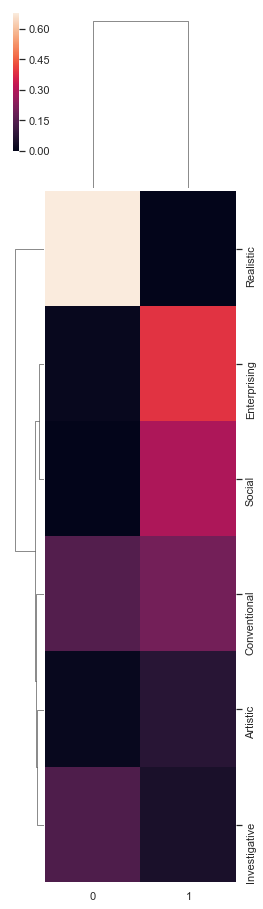

In [56]:
def plf(dd,n):
    sns.clustermap(OnetCluster(matrix(dd),n).fn.apply(lambda x: x**2).sort_values(
    1,axis=1,ascending = False).T,figsize=(2*n, 16),method = 'single')
plf(din,2)

# SOLVE WITH BOOSTRAPPED LSA

In [57]:
Xy = pd.merge(workers[['SOCP','DEAR','DEYE','log FTE']],dall,right_index = True, left_on='SOCP')
X = (Xy.drop(['SOCP','DEAR','DEYE','log FTE'],axis = 1))
y = (Xy[['log FTE']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def lsa(Xy):
    X = (Xy.drop(['SOCP','DEAR','DEYE','log FTE'],axis = 1))
    y = (Xy[['log FTE']])
    xtx = X.T @ X
    xty = X.T @ y
    xtx_inv = pd.DataFrame(np.linalg.pinv(xtx.values), xtx.columns, xtx.index)
    k = xtx_inv @ xty
    return k

In [ ]:
res = {}
for i in range(20):
    res[i] = pd.concat([lsa(Xy.sample(10000)) for i in range(100)],axis = 1)

In [253]:
fin = pd.concat(list(res.values()),axis = 1)
final = pd.concat([fin.T.mean(),fin.T.std()],axis = 1)
final.columns = ['mean','std']
final.sort_values('mean',ascending = False)

y_hat = dall @ final[['mean']]
y_test = Xy.groupby('SOCP').mean()[['log FTE']]

y_final = y_test.merge(y_hat,left_index = True, right_index = True)
y_final.columns = ['test','predict']

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

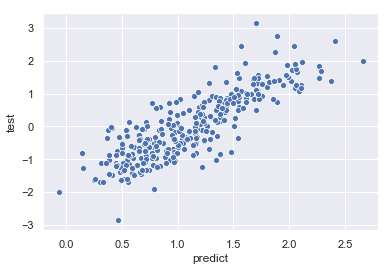

In [108]:
sns.scatterplot(x='predict',y='test',data = y_final)

In [50]:
def fnn(n):
    return fin[:n].std().max()

In [71]:
fin.mean().sort_values(ascending=False)

Stamina                              0.321967
Control Precision                    0.233401
Glare Sensitivity                    0.194829
Physics                              0.179887
Reading Comprehension                0.168712
Judgment and Decision Making         0.139964
Rate Control                         0.129095
Monitoring                           0.127335
Sales and Marketing                  0.114098
Personnel and Human Resources        0.110120
Visual Color Discrimination          0.093877
Near Vision                          0.089998
Management of Material Resources     0.087691
Psychology                           0.085442
Explosive Strength                   0.085409
Auditory Attention                   0.083698
Engineering and Technology           0.080883
Therapy and Counseling               0.076646
Problem Sensitivity                  0.075569
Operations Analysis                  0.075191
Written Comprehension                0.074406
Law and Government                

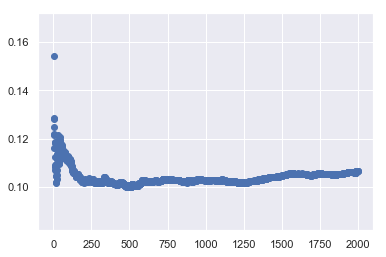

In [67]:
plt.scatter(x=range(len(fin)),y=[fnn(n) for n in range(len(fin))])

In [127]:
dall

,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Philosophy and Theology,Physics,Production and Processing,Psychology,Public Safety and Security,Sales and Marketing,Sociology and Anthropology,Telecommunications,Therapy and Counseling,Transportation
SOCP_shave,,,,,,,,,,,,,,,,,,,,,
111011,0.000000,1.870000,3.870000,1.185000,4.750000,1.690000,0.000000,0.000000,0.000000,0.000000,...,2.120000,1.685000,2.635000,3.590000,3.495000,4.370000,3.175000,1.200000,1.520000,2.195000
111021,1.500000,2.000000,3.000000,1.380000,3.750000,1.880000,0.000000,0.750000,0.750000,0.500000,...,0.870000,1.410000,4.340000,2.780000,3.120000,4.050000,1.300000,2.330000,1.480000,2.310000
112011,0.500000,1.250000,3.880000,0.120000,4.500000,1.000000,0.000000,0.000000,0.000000,0.000000,...,2.110000,0.490000,2.680000,2.740000,2.190000,5.580000,2.770000,1.910000,1.420000,1.590000
112021,0.120000,1.620000,3.620000,0.000000,4.380000,0.750000,0.000000,0.250000,0.000000,0.000000,...,1.120000,0.370000,2.920000,2.860000,2.260000,6.050000,2.440000,2.560000,1.100000,1.530000
112022,0.500000,1.880000,3.620000,0.880000,4.380000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.220000,0.910000,3.090000,2.950000,1.480000,6.130000,1.680000,1.960000,1.040000,2.130000
112031,0.000000,1.500000,3.380000,0.000000,4.120000,0.880000,0.000000,0.000000,0.000000,0.000000,...,2.130000,0.260000,0.770000,3.270000,1.690000,5.470000,3.250000,1.110000,1.540000,1.010000
113011,2.000000,2.250000,3.120000,1.750000,3.880000,1.620000,0.000000,0.750000,0.750000,0.750000,...,1.310000,1.140000,3.020000,1.990000,3.290000,2.000000,1.450000,2.190000,1.390000,1.410000
113021,2.000000,1.750000,3.120000,2.000000,4.000000,1.120000,0.000000,0.500000,0.000000,0.000000,...,0.690000,1.200000,1.420000,2.270000,1.520000,1.770000,1.690000,2.810000,0.780000,0.410000
113031,0.125000,1.560000,3.560000,0.190000,4.440000,0.310000,0.000000,0.000000,0.000000,0.000000,...,0.715000,0.140000,1.790000,2.930000,1.845000,2.805000,1.870000,1.260000,0.980000,1.070000


## WITH TRAIN TEST SPLIT

In [ ]:
Xy = pd.merge(workers[['SOCP','DEAR','DEYE','log FTE']],dall,right_index = True, left_on='SOCP')
X = (Xy.drop(['SOCP','DEAR','DEYE','log FTE'],axis = 1))
y = (Xy[['log FTE']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def sampler(X_train,y_train,n=10000):
    aaa = y_train.sample(10).index
    return (X_train.loc[aaa],y_train.loc[aaa])   

def lsa(X,y):
    xtx = X.T @ X
    xty = X.T @ y
    xtx_inv = pd.DataFrame(np.linalg.pinv(xtx.values), xtx.columns, xtx.index)
    k = xtx_inv @ xty
    return k

# CHECK CATEGORIES

In [ ]:
datadic

In [252]:
1+1

2